In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [2]:
DATASET_SIZE = 70000
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = train_test_split(x, y, test_size=(1-TRAIN_RATIO))
x_valid_orig, x_test_orig, y_valid_orig, y_test_orig = train_test_split(x_valid_orig, y_valid_orig, test_size=((TEST_RATIO/(VALIDATION_RATIO+TEST_RATIO))))

In [3]:
# change the format of data 
def data_format(y): 
    y_10 = []
    for i in np.arange(10): 
        temp = (y==i).astype(int)
        y_10 = np.append(y_10, temp)
        #print(y_10)
    y_10 = y_10.reshape(y.shape[0], -1, order='F')
    return y_10 

# normalize data 
x_train = x_train_orig.reshape(x_train_orig.shape[0], -1).astype('float32')/255.
y_train = data_format(y_train_orig)

x_valid = x_valid_orig.reshape(x_valid_orig.shape[0], -1).astype('float32')/255.
y_valid = data_format(y_valid_orig)

x_test = x_test_orig.reshape(x_test_orig.shape[0], -1).astype('float32')/255.
y_test = data_format(y_test_orig)

In [4]:
# minimization function 
def min_fun(x, y, w, lambda_): 
    N = np.shape(x)[0]
    K = np.shape(w)[0]
    I = np.identity(K)
    one = np.ones(N)
    x_ = np.c_[x, one]
    S = np.cos(x_.dot(w.T)) 
    beta = np.linalg.inv(np.dot(S.T, S) + lambda_ * N * I).dot(S.T).dot(y)
    return beta, S

In [5]:
def error_compute(y, pred):
    #error = - np.sum(np.diagonal(y.dot(np.log(pred+1e-10).T)))
    # y pred in N*10
    #error = np.mean(np.sum((y-pred)**2, axis=1))
    N = np.shape(y)[0]
    y_index = np.argmax(y, 1)
    pred_index = np.argmax(pred, 1)
    error = np.linalg.norm((y_index-pred_index), ord=2)/N
    return error

In [6]:
def accuracy_compute(y, pred): 
    y_index = np.argmax(y, 1)
    pred_index = np.argmax(pred, 1)
    accuracy = np.mean((pred_index==y_index).astype('int'))
    return accuracy

In [7]:
# Metropolis algorithm 1
#def algorithm_1(x_train, y_train, x_test, y_test, x_validation, y_validation, K, M, lambda_, delta, gamma):
def algorithm_1(x_train, y_train, x_valid, y_valid, x_test, y_test, K, M, lambda_, delta, gamma):
    
    # normalize the data 
    #x_mean = np.mean(x_train)
    #x_std = np.std(x_train, ddof=1)
    #y_mean = np.mean(y_train)
    #y_std = np.std(y_train, ddof=1)
    
    #x_train_norm = (x_train - x_mean)/x_std
    #y_train_norm = (y_train - y_mean)/y_std
    #x_test_norm = (x_test - x_mean)/x_std
    #y_test_norm = (y_test - y_mean)/y_std
    #x_validation_norm = (x_validation - x_mean)/x_std
    #y_validation_norm = (y_validation - y_mean)/y_std
    
    N = np.shape(x_train)[0]
    d = np.shape(x_train)[1] 
    w = np.zeros(K*(d+1)).reshape((K, d+1)) #? 
    
    error_train_list = []
    error_valid_list = []
    error_test_list = []
    
    accuracy_train_list = []
    accuracy_valid_list = []
    accuracy_test_list = []
  
    #beta, S = min_fun(x_train_norm, y_train_norm, w, lambda_)
    beta = np.zeros(10*K).reshape(10, K)
    S = np.zeros(10*N*K).reshape(10, N, K)
    for i in np.arange(10): 
        beta[i],  S[i] = min_fun(x_train, y_train[:,i], w, lambda_)
    #print(beta)
    
    
    for epoch in range(M): 
        #print('w=', i)
        r_n = np.random.normal(0, 0.1, K*(d+1)).reshape((K, d+1))
        w_temp = w + delta * r_n
        #print(w_temp)
        #beta_temp, S_temp = min_fun(x_train_norm, y_train_norm, w_temp, lambda_)
        beta_temp = np.zeros(10*K).reshape(10, K)
        S_temp = np.zeros(10*N*K).reshape(10, N, K)
        for i in np.arange(10): 
            beta_temp[i],  S_temp[i] = min_fun(x_train, y_train[:,i], w_temp, lambda_)
        #print(beta_temp)
        
        for k in range(K): 
            #print('k=', k)
            r_u = np.random.uniform(0, 1)
            #print(np.linalg.norm(beta_temp[:,k], ord=2))
            #print(np.linalg.norm(beta[:,k], ord=2))
            #print(r_u)
            #print((np.linalg.norm(beta_temp[:,k], ord=2)/np.linalg.norm(beta[:,k], ord=2))**gamma)
            
            if (np.linalg.norm(beta_temp[:,k], ord=2)
                /np.linalg.norm(beta[:,k], ord=2))**gamma > r_u: 
                #print('yes')
                w[k] = w_temp[k]
                #print('w_k', w[k])
                beta[:,k] = beta_temp[:,k]
                #print('beta_k', beta[k])
                
        #beta, S = min_fun(x_train_norm, y_train_norm, w, lambda_)
        beta = np.zeros(10*K).reshape(10, K)
        S = np.zeros(10*N*K).reshape(10, N, K)
        for i in np.arange(10): 
            beta[i],  S[i] = min_fun(x_train, y_train[:,i], w, lambda_)
        
        #f_est_train = S.dot(beta) * y_std + y_mean
        pred_train = np.zeros(10*N).reshape(N, 10)
        for i in np.arange(10): 
            pred_train[:,i] = S[i].dot(beta[i])
        error_train = error_compute(y_train, pred_train)
        error_train_list = np.append(error_train_list, error_train)
        accuracy_train = accuracy_compute(y_train, pred_train)
        accuracy_train_list = np.append(accuracy_train_list, accuracy_train)
        
        #beta_validation, S_validation = min_fun(x_valid, y_valid, w, lambda_)
        #f_est_validation = S_validation.dot(beta) * y_std + y_mean
        N_valid = np.shape(x_valid)[0]
        beta_valid = np.zeros(10*K).reshape(10, K)
        S_valid = np.zeros(10*N_valid*K).reshape(10, N_valid, K)
        for i in np.arange(10): 
            beta_valid[i],  S_valid[i] = min_fun(x_valid, y_valid[:,i], w, lambda_)
        pred_valid = np.zeros(10*N_valid).reshape(N_valid, 10)
        for i in np.arange(10): 
            pred_valid[:,i] = S_valid[i].dot(beta[i])
        error_valid= error_compute(y_valid, pred_valid)
        error_valid_list = np.append(error_valid_list, error_valid)
        accuracy_valid= accuracy_compute(y_valid, pred_valid)
        accuracy_valid_list = np.append(accuracy_valid_list, accuracy_valid)
        
        #beta_test, S_test = min_fun(x_test_norm, y_test_norm, w, lambda_)
        #f_est_test = S_test.dot(beta) * y_std + y_mean
        N_test = np.shape(x_test)[0]
        beta_test = np.zeros(10*K).reshape(10, K)
        S_test = np.zeros(10*N_test*K).reshape(10, N_test, K)
        for i in np.arange(10): 
            beta_test[i],  S_test[i] = min_fun(x_test, y_test[:,i], w, lambda_)
        pred_test = np.zeros(10*N_test).reshape(N_test, 10)
        for i in np.arange(10): 
            pred_test[:,i] = S_test[i].dot(beta[i])
        error_test = error_compute(y_test, pred_test)
        error_test_list = np.append(error_test_list, error_test)
        accuracy_test = accuracy_compute(y_test, pred_test)
        accuracy_test_list = np.append(accuracy_test_list, accuracy_test)
    
        # Print the training loss for every epoch
        print("\nEnd of epoch  " + str(epoch) + ", Training error " + str(error_train) + ",Accuracy " + str(accuracy_train)) 
        print("\nEnd of epoch  " + str(epoch) + ", Validation error " + str(error_valid) + ", Validation accuracy " + str(accuracy_valid))
        
    #error_valid_min = np.min(error_validation_list)
    
    #error_test_end = error_compute(y_test_norm, S_test, beta_test)
        
    #return beta, w, f_est_train, f_est_validation, error_train_list, error_validation_list, error_test_list,error_valid_min, error_test_end
    return beta, w, pred_train, pred_valid, pred_test, error_train_list, error_valid_list, error_test_list, accuracy_train_list, accuracy_valid_list, accuracy_test_list

In [8]:
def result_plot(x_train, y_train, x_valid, y_valid, x_test, y_test,
              M = 100, K = 2**5, lambda_ = 0.1, delta = 0.1, gamma = 1): 
    beta, w, pred_train, pred_valid, pred_test, error_train_list, error_valid_list, error_test_list, accuracy_train_list, accuracy_valid_list, accuracy_test_list = algorithm_1(
    x_train, y_train, x_valid, y_valid, x_test, y_test, K, M, lambda_, delta, gamma)
    
    plt.figure(figsize=(10, 6))
    epoch_list = np.arange(1, 101)
    plt.subplot(1, 2,  1)
    plt.semilogy(epoch_list, error_train_list, label = 'training_loss')
    plt.semilogy(epoch_list, error_valid_list, label = 'validation_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, accuracy_train_list*100, label = 'accuracy_loss')
    plt.plot(epoch_list, accuracy_valid_list*100, label = 'accuracy_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('%')
    plt.title('Accuracy')
    plt.tight_layout()
    plt.show()
    
    accuracy_valid_max = np.max(accuracy_valid_list)
    return accuracy_valid_max


 for k=1

End of epoch  0, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  0, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  1, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  1, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  2, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  2, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  3, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  3, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  4, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  4, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  5, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  5, 

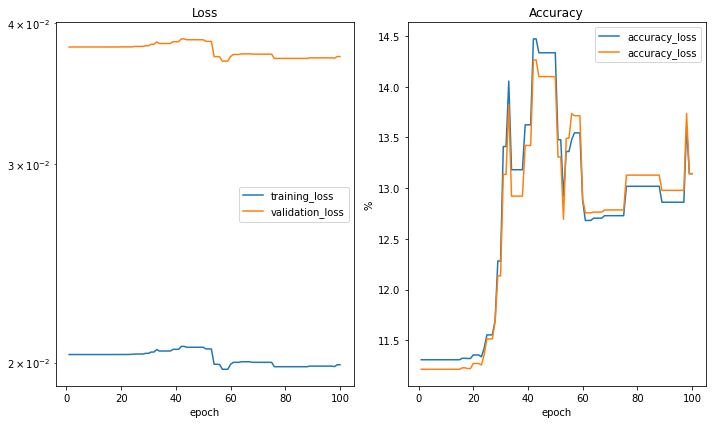


 for k=2

End of epoch  0, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  0, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  1, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  1, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  2, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  2, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  3, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  3, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  4, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  4, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  5, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  5, 

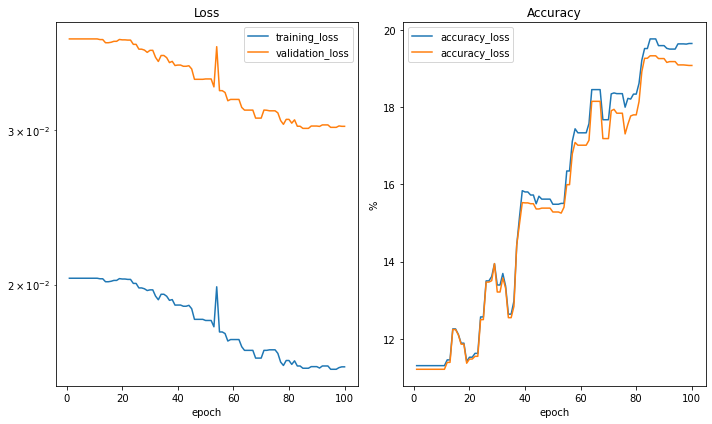


 for k=4

End of epoch  0, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  0, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  1, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  1, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  2, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  2, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  3, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  3, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  4, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  4, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  5, Training error 0.020331452867340723,Accuracy 0.11310434906834833

End of epoch  5,

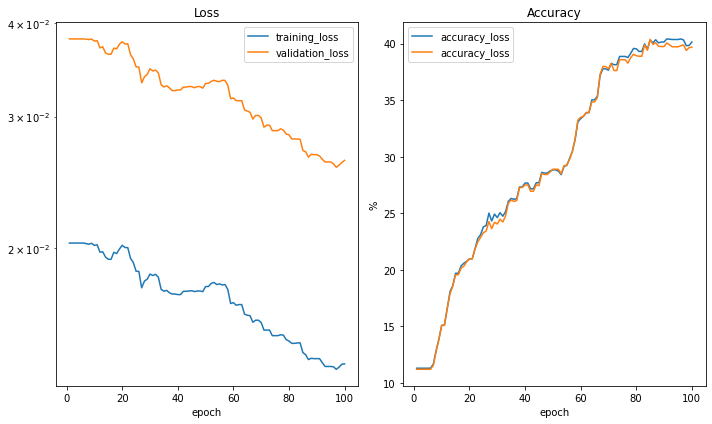


 for k=8

End of epoch  0, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  0, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  1, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  1, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  2, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  2, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  3, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  3, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  4, Training error 0.02033124800631617,Accuracy 0.11324720912671687

End of epoch  4, Validation error 0.03808663593354884, Validation accuracy 0.11235714285714286

End of epoch  5, Training error 0.020294257240710694,Accuracy 0.11561460437968121

End of epoch  5,

<ipython-input-7-1fa4392259e9>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  9, Training error 0.019722070522131173,Accuracy 0.18973856609318557

End of epoch  9, Validation error 0.036960403522843584, Validation accuracy 0.1915

End of epoch  10, Training error 0.019589440826535045,Accuracy 0.24102532704749077

End of epoch  10, Validation error 0.03665851795661562, Validation accuracy 0.24321428571428572

End of epoch  11, Training error 0.019221859613172798,Accuracy 0.27178105675626035

End of epoch  11, Validation error 0.03599617326600035, Validation accuracy 0.2767142857142857

End of epoch  12, Training error 0.01845099278674859,Accuracy 0.2837608930794506

End of epoch  12, Validation error 0.034489498549617706, Validation accuracy 0.2864285714285714

End of epoch  13, Training error 0.017045233114847323,Accuracy 0.3263535990530419

End of epoch  13, Validation error 0.03190739150499553, Validation accuracy 0.328

End of epoch  14, Training error 0.017126215730003117,Accuracy 0.3243127410763485

End of epoch  14, Validation error 0.031886

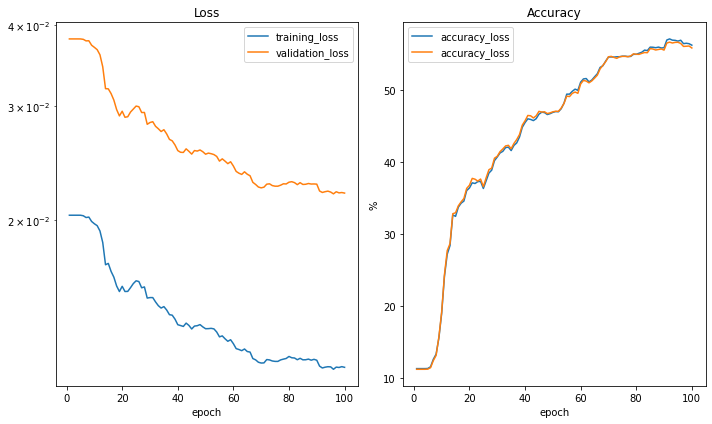


 for k=16

End of epoch  0, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  0, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714


<ipython-input-7-1fa4392259e9>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  1, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  1, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  2, Training error 0.020332231320409306,Accuracy 0.11324720912671687

End of epoch  2, Validation error 0.03808958291358166, Validation accuracy 0.11221428571428571

End of epoch  3, Training error 0.020324179036456648,Accuracy 0.11969632033306803

End of epoch  3, Validation error 0.03806693889367378, Validation accuracy 0.11871428571428572

End of epoch  4, Training error 0.020218053909381008,Accuracy 0.1449417335047654

End of epoch  4, Validation error 0.03786192692143496, Validation accuracy 0.14207142857142857

End of epoch  5, Training error 0.020190017244524475,Accuracy 0.15065613583950693

End of epoch  5, Validation error 0.03781473365809487, Validation accuracy 0.1477857142857143

End of epoch  6, Training error 0.019438569603119505,Accuracy 0.22578011796159106

End of epoch  6, Validat

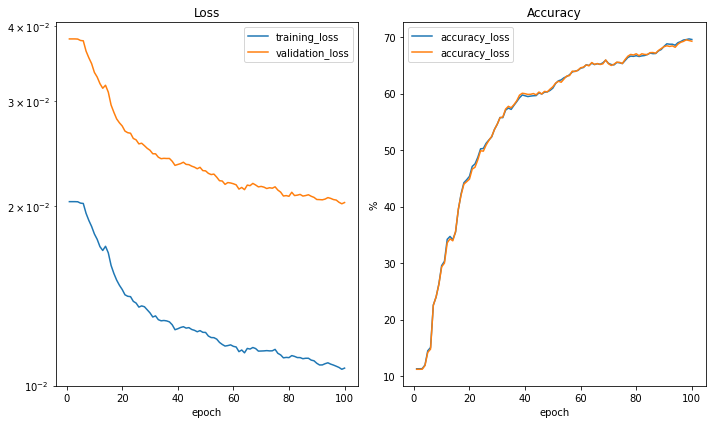


 for k=32


<ipython-input-7-1fa4392259e9>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  0, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  1, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  1, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  2, Training error 0.020323164591255508,Accuracy 0.11569623869874895

End of epoch  2, Validation error 0.03807069149648332, Validation accuracy 0.11557142857142857

End of epoch  3, Training error 0.019649636659052807,Accuracy 0.19471825955631747

End of epoch  3, Validation error 0.03700909981866291, Validation accuracy 0.1925

End of epoch  4, Training error 0.01808377524413287,Accuracy 0.2821282066980959

End of epoch  4, Validation error 0.03378103259619673, Validation accuracy 0.2884285714285714

End of epoch  5, Training error 0.017434267424100584,Accuracy 0.32733321088185474

End of epoch  5, Validation error 0.032

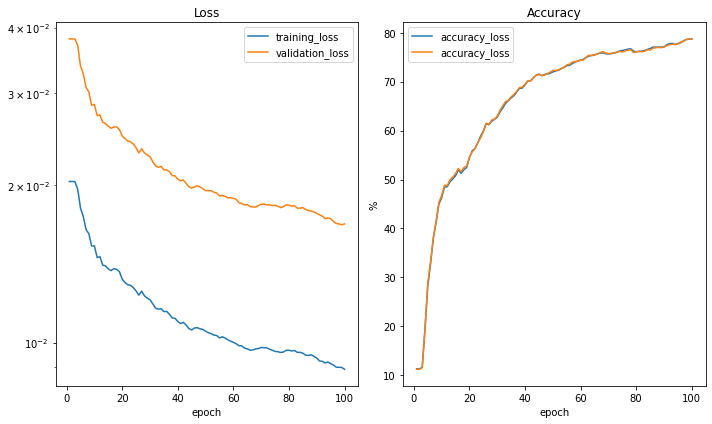


 for k=64


<ipython-input-7-1fa4392259e9>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  0, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  1, Training error 0.020324015089147475,Accuracy 0.11439008959366517

End of epoch  1, Validation error 0.038069485343063335, Validation accuracy 0.11414285714285714

End of epoch  2, Training error 0.020212872118731687,Accuracy 0.15179901630645523

End of epoch  2, Validation error 0.03784076465120327, Validation accuracy 0.15057142857142858

End of epoch  3, Training error 0.019703730715210456,Accuracy 0.222698422416784

End of epoch  3, Validation error 0.03686267953984278, Validation accuracy 0.22278571428571428

End of epoch  4, Training error 0.018320289966276854,Accuracy 0.3283128227106676

End of epoch  4, Validation error 0.03425713094244997, Validation accuracy 0.3301428571428571

End of epoch  5, Training error 0.01667072436626279,Accuracy 0.3974366823812731

End of epoch  5, Validation

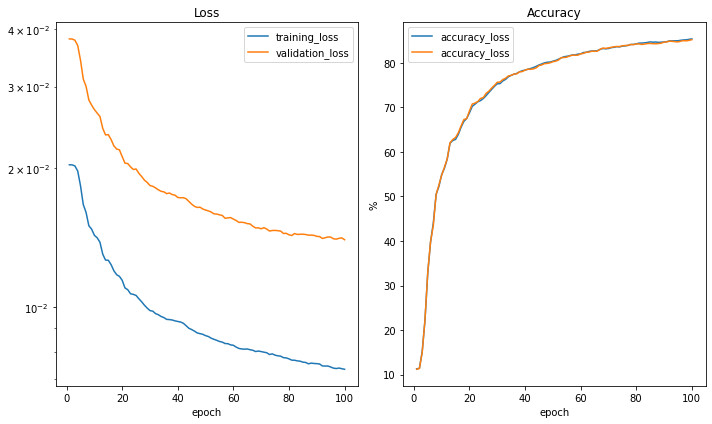


 for k=128


<ipython-input-7-1fa4392259e9>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.020332313261103813,Accuracy 0.1130839404885814

End of epoch  0, Validation error 0.03808904711598968, Validation accuracy 0.11214285714285714

End of epoch  1, Training error 0.02032881000166627,Accuracy 0.11792077389334477

End of epoch  1, Validation error 0.03808107623672076, Validation accuracy 0.11814285714285715

End of epoch  2, Training error 0.019855440023665266,Accuracy 0.20698381599624482

End of epoch  2, Validation error 0.03714127743893468, Validation accuracy 0.20957142857142858

End of epoch  3, Training error 0.01826364932211387,Accuracy 0.3471703504153146

End of epoch  3, Validation error 0.03403996750520044, Validation accuracy 0.35235714285714287

End of epoch  4, Training error 0.016439690565310604,Accuracy 0.4440498785689504

End of epoch  4, Validation error 0.03076333293161234, Validation accuracy 0.447

End of epoch  5, Training error 0.015019231131097984,Accuracy 0.5197657095042756

End of epoch  5, Validation error 0.02808

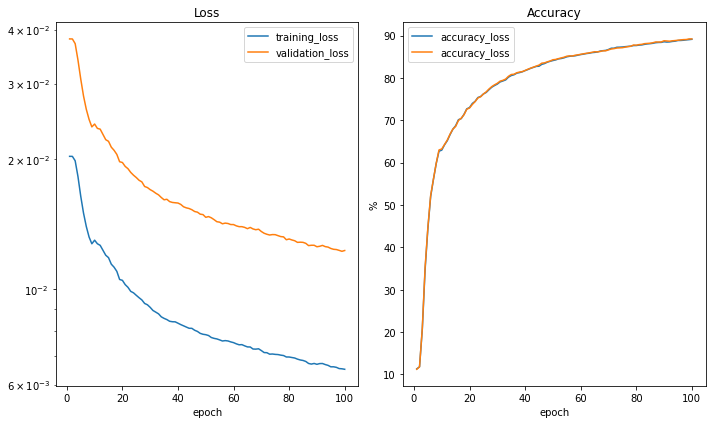


 for k=256


<ipython-input-7-1fa4392259e9>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.02033228253338207,Accuracy 0.1131451662278822

End of epoch  0, Validation error 0.03808898014076073, Validation accuracy 0.11221428571428571

End of epoch  1, Training error 0.020061166771129076,Accuracy 0.18796301965346232

End of epoch  1, Validation error 0.037597153061998546, Validation accuracy 0.18864285714285714

End of epoch  2, Training error 0.01722567554006047,Accuracy 0.41329414886018084

End of epoch  2, Validation error 0.0322521949893748, Validation accuracy 0.4115714285714286

End of epoch  3, Training error 0.015029308255288197,Accuracy 0.5299904079675095

End of epoch  3, Validation error 0.02809985837715782, Validation accuracy 0.5261428571428571

End of epoch  4, Training error 0.013819773429053134,Accuracy 0.5916651360231842

End of epoch  4, Validation error 0.025613194144536413, Validation accuracy 0.5914285714285714

End of epoch  5, Training error 0.012748013148436443,Accuracy 0.6242780464907447

End of epoch  5, Validation e

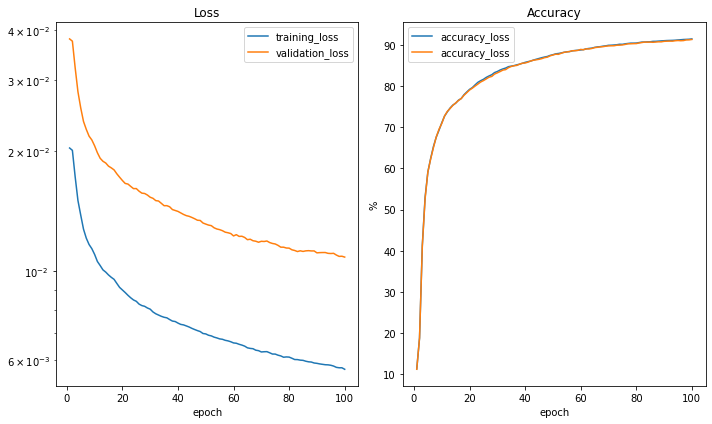


 for k=512


<ipython-input-7-1fa4392259e9>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.020316338825141327,Accuracy 0.1249005081736362

End of epoch  0, Validation error 0.03806372208252249, Validation accuracy 0.12557142857142858

End of epoch  1, Training error 0.01743839995869399,Accuracy 0.3882324129063858

End of epoch  1, Validation error 0.03261385081995259, Validation accuracy 0.39057142857142857

End of epoch  2, Training error 0.014242293756522504,Accuracy 0.5729708769566726

End of epoch  2, Validation error 0.02680694396789681, Validation accuracy 0.5695

End of epoch  3, Training error 0.01266929061065773,Accuracy 0.6470540215106431

End of epoch  3, Validation error 0.023720201499643156, Validation accuracy 0.6480714285714285

End of epoch  4, Training error 0.012172464683101071,Accuracy 0.6650747974448458

End of epoch  4, Validation error 0.022701928354666442, Validation accuracy 0.6658571428571428

End of epoch  5, Training error 0.011582278081162856,Accuracy 0.6893405987877304

End of epoch  5, Validation error 0.021606

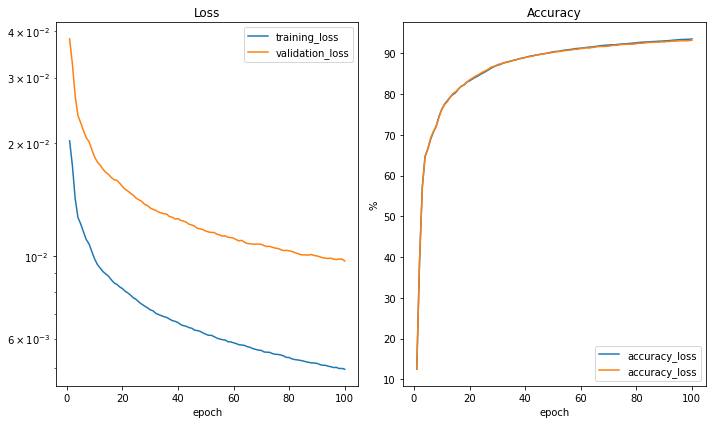


 for k=1024


<ipython-input-7-1fa4392259e9>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.019924721981775004,Accuracy 0.19886120124900508

End of epoch  0, Validation error 0.037342594818184534, Validation accuracy 0.1972857142857143

End of epoch  1, Training error 0.014347304152712752,Accuracy 0.5538684462948223

End of epoch  1, Validation error 0.026752074113753407, Validation accuracy 0.5548571428571428

End of epoch  2, Training error 0.012122885348417187,Accuracy 0.6662176779117941

End of epoch  2, Validation error 0.022627191516367367, Validation accuracy 0.6679285714285714

End of epoch  3, Training error 0.011166738632293354,Accuracy 0.7097491785546644

End of epoch  3, Validation error 0.020949161007992073, Validation accuracy 0.7109285714285715

End of epoch  4, Training error 0.010377115616578116,Accuracy 0.7385660931855752

End of epoch  4, Validation error 0.019501177358491637, Validation accuracy 0.74

End of epoch  5, Training error 0.009974618981716627,Accuracy 0.7574440294699892

End of epoch  5, Validation error 0.0186

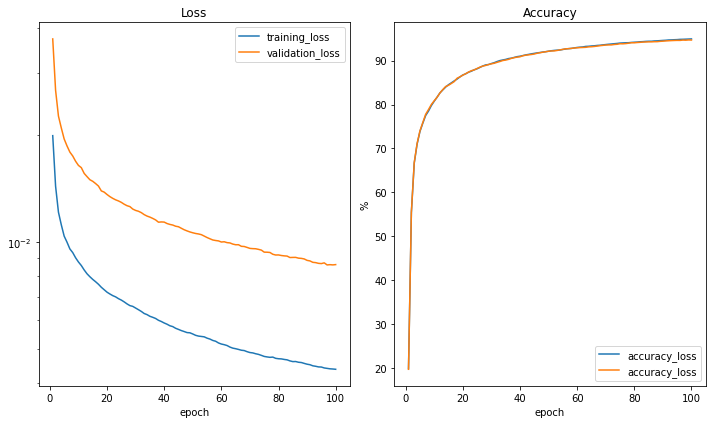

In [9]:
K = np.arange(0,11) 
K = 2**K

accuracy_valid_max_list = []

for k in K: 
    
    print("\n for k=" + str(k))
    
    seed = 1
    np.random.seed(seed)
    d = 784

    accuracy_valid_max = result_plot(x_train, y_train, x_valid, y_valid, x_test, y_test, 
                                     M = 100, K = k, lambda_ = 0.1, delta = 0.1, gamma = 3*d - 2)
    
    accuracy_valid_max_list = np.append(accuracy_valid_max_list, accuracy_valid_max)

[[   1.      14.264]
 [   2.      19.329]
 [   4.      40.371]
 [   8.      56.6  ]
 [  16.      69.536]
 [  32.      78.729]
 [  64.      85.207]
 [ 128.      89.2  ]
 [ 256.      91.336]
 [ 512.      93.2  ]
 [1024.      94.7  ]]


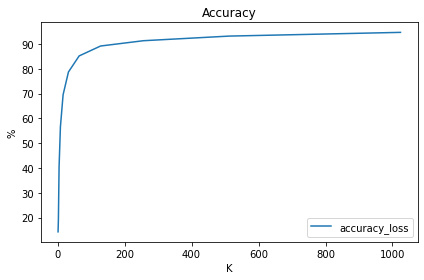

In [10]:
accuracy_table = np.append(K, accuracy_valid_max_list*100).reshape((11,2), order='F')
np.set_printoptions(precision=3, suppress=True)
print(accuracy_table)

plt.plot(K, accuracy_valid_max_list*100, label = 'accuracy_loss')
plt.legend()
plt.xlabel('K')
plt.ylabel('%')
plt.title('Accuracy')
plt.tight_layout()
plt.show()